## Deep Learning with Pytorch
Why not numpy? 
- Torch handles CUDA so you can use GPU, but numpy does not use GPU
- No need for back propagaion with pytorch, back propagaion with numpy can be challenging (in Transformers, etc.)

Back propagation is the learning algorithm for a NN -> uses gradient descent (Optimization)

Chain Rule: Reaching from Output to Model Parameters

### Required Libraries

In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

### Import Dataset

Datasets in Pytorch are:
 1. Iterable Style -> for data streaming
 2. Map Style -> it is not for streaming

Tensor: Arrays that can have higher dimensions

### Custom Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        if self.train:
            self.data_dir = os.path.join(self.root_dir, 'train')
        else:
            self.data_dir = os.path.join(self.root_dir, 'test')
        self.images = self._load_images()
        self.classes = self._get_classes()

    def _load_images(self):
        images = []
        for img_name in os.listdir(self.data_dir):
            img_path = os.path.join(self.data_dir, img_name)
            label = img_name.split('_')[-1][0]
            images.append((img_path, label))
        return images

    def _get_classes(self):
        classes = set()
        for _, label in self.images:
            classes.add(label)
        return sorted(classes)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(int(label))    
        return image, label


In [3]:
train_dataset = CustomDataset(root_dir='Dataset', transform=transforms.ToTensor(), train=True)
test_dataset = CustomDataset(root_dir='Dataset', transform=transforms.ToTensor(), train=False)

sample_image = train_dataset[0][0]
print(sample_image.shape)

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

torch.Size([1, 128, 128])
Number of classes: 6


### Model

In [4]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Model with Separated Paths

In [5]:
class NeuralNetSeparatedPaths(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetSeparatedPaths, self).__init__()
        self.flatten = Flatten()
        self.fc1_a = nn.Linear(input_size, hidden_size)
        self.fc1_b = nn.Linear(input_size, hidden_size)
        self.fc2_a = nn.Linear(hidden_size, num_classes)
        self.fc2_b = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.flatten(x)
        
        x_a = F.relu(self.fc1_a(x))
        x_a = self.dropout(x_a)
        x_a = self.fc2_a(x_a)
        
        x_b = F.relu(self.fc1_b(x))
        x_b = self.dropout(x_b)
        x_b = self.fc2_b(x_b)
        
        x_concat = torch.cat((x_a, x_b), dim=1)
        
        return x_concat


### Training Loop

In [6]:
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    

    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Epoch')
    plt.show()


### Testing Loop

In [7]:
def test(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_predicted.extend(predicted.tolist())
            all_labels.extend(labels.tolist())
    
    test_accuracy = correct / total
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"Test Accuracy: {test_accuracy:.2%}, Avg Test Loss: {avg_test_loss:.4f}")
    
    f1 = f1_score(all_labels, all_predicted, average='macro')
    print(f"F1 Score: {f1:.4f}")


In [8]:
model = NeuralNetSeparatedPaths(input_size=128*128, hidden_size=256, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

NeuralNetSeparatedPaths(
  (flatten): Flatten()
  (fc1_a): Linear(in_features=16384, out_features=256, bias=True)
  (fc1_b): Linear(in_features=16384, out_features=256, bias=True)
  (fc2_a): Linear(in_features=256, out_features=6, bias=True)
  (fc2_b): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Train Model

Epoch 1/5, Loss: 1.1694
Epoch 2/5, Loss: 0.2962
Epoch 3/5, Loss: 0.1649
Epoch 4/5, Loss: 0.1136
Epoch 5/5, Loss: 0.0807


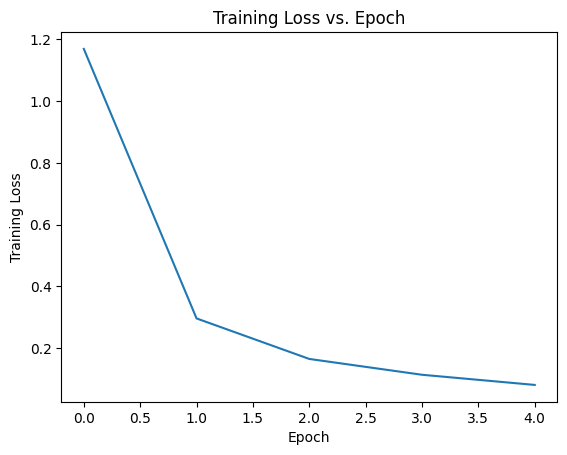

In [9]:
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train(model, train_loader, criterion, optimizer, num_epochs)

### Test Model

In [10]:
test(model, test_loader, criterion)

Test Accuracy: 99.17%, Avg Test Loss: 0.0324
F1 Score: 0.9917


### Model Weights

In [11]:
def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(f"Parameter name: {name}, Shape: {param.shape}")

print_model_parameters(model)

Parameter name: fc1_a.weight, Shape: torch.Size([256, 16384])
Parameter name: fc1_a.bias, Shape: torch.Size([256])
Parameter name: fc1_b.weight, Shape: torch.Size([256, 16384])
Parameter name: fc1_b.bias, Shape: torch.Size([256])
Parameter name: fc2_a.weight, Shape: torch.Size([6, 256])
Parameter name: fc2_a.bias, Shape: torch.Size([6])
Parameter name: fc2_b.weight, Shape: torch.Size([6, 256])
Parameter name: fc2_b.bias, Shape: torch.Size([6])


Link: https://pytorch.org/tutorials/beginner/basics/